# Introduction
This part of the repository scrapes the data regarding interiors from Dezeen.com

# Environment setup

## Google Drive mount
I'm using Google Colaboratory as my default platform, therefore I need to set up my environment to integrate it with Google Drive. You can skip this bit if you're working locally.

1. Mount Google Drive on the runtime to be able to read and write files. This will ask you to log in to your Google Account and provide an authorization code.
2. Create a symbolic link to a working directory 
3. Change the directory to the one where I cloned my repository.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/dezeenAI /mydrive
!ls /mydrive

ln: failed to create symbolic link '/mydrive/dezeenAI': File exists
classes.gsheet	       dezeen_2-download.ipynb	files
darknet		       dezeen_3-dataset.ipynb	LICENSE
data		       dezeen_4-model.ipynb	OIDv4_ToolKit
dezeen_0-test.ipynb    dezeen_5-database.ipynb	README.md
dezeen_1-scrape.ipynb  dezeenAI


In [ ]:
%cd /mydrive

/content/gdrive/My Drive/Colab Notebooks/dezeenAI


## Libraries & functions
- `requests` - http handling
- `BeautifulSoup` - html parsing & web-scraping
- `urllib.request` - url-opening
- `tqdm` - loop progress bar
- `numpy` - linear algebra
- `pandas` - data manipulation & analysis
- `sys` - system-specific parameters & functions

In [ ]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import timeit
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os

# Database

## List of results
Let's get a list of results of the object detection from the previous notebook.

In [ ]:
results = [] 
DIR = '/mydrive/files/tmp/'
os.chdir(DIR)

for filename in os.listdir(os.getcwd()):
  if filename.endswith('.json'):
    results.append(DIR + filename)

results

['/mydrive/files/tmp/dezeen_results-0.json',
 '/mydrive/files/tmp/dezeen_results-1.json',
 '/mydrive/files/tmp/dezeen_results-2.json',
 '/mydrive/files/tmp/dezeen_results-3.json',
 '/mydrive/files/tmp/dezeen_results-4.json',
 '/mydrive/files/tmp/dezeen_results-5.json',
 '/mydrive/files/tmp/dezeen_results-6.json',
 '/mydrive/files/tmp/dezeen_results-7.json',
 '/mydrive/files/tmp/dezeen_results-8.json',
 '/mydrive/files/tmp/dezeen_results-9.json',
 '/mydrive/files/tmp/dezeen_results-10.json',
 '/mydrive/files/tmp/dezeen_results-11.json',
 '/mydrive/files/tmp/dezeen_results-12.json',
 '/mydrive/files/tmp/dezeen_results-13.json',
 '/mydrive/files/tmp/dezeen_results-14.json',
 '/mydrive/files/tmp/dezeen_results-15.json',
 '/mydrive/files/tmp/dezeen_results-16.json',
 '/mydrive/files/tmp/dezeen_results-17.json',
 '/mydrive/files/tmp/dezeen_results-18.json',
 '/mydrive/files/tmp/dezeen_results-20.json',
 '/mydrive/files/tmp/dezeen_results-23.json',
 '/mydrive/files/tmp/dezeen_results-22.json'

## Concatenate DataFrames
Let's import all results JSON files and concatenate them into one DataFrame using `pd.concat()`

In [ ]:
df = pd.DataFrame()

for file in tqdm(results):
  df_tmp = pd.read_json(file)
  df = pd.concat([df, df_tmp])

df.head()

100%|██████████| 24/24 [00:01<00:00, 13.93it/s]


,frame_id,filename,objects
0,1,/mydrive/data/dezeen/1567145/dreamscapes-artif...,[]
1,2,/mydrive/data/dezeen/1567145/dreamscapes-artif...,[]
2,3,/mydrive/data/dezeen/1567145/dreamscapes-artif...,[]
3,4,/mydrive/data/dezeen/1567145/dreamscapes-artif...,"[{'class_id': 56, 'name': 'chair', 'relative_c..."
4,5,/mydrive/data/dezeen/1567145/dreamscapes-artif...,"[{'class_id': 60, 'name': 'diningtable', 'rela..."


In [ ]:
df.rename(columns={'filename': 'filepath'}, inplace=True)


df['article_id'] = df.apply(lambda x: x.filepath.split('/')[4], axis=1)
df['filename'] = df.apply(lambda x: x.filepath.split('/')[5], axis=1)
df.drop(['frame_id'], axis=1, inplace=True)
df.reset_index(inplace=True)
df.head()

,index,filepath,objects,article_id,filename
0,0,/mydrive/data/dezeen/1567145/dreamscapes-artif...,[],1567145,dreamscapes-artificial-architecture-book-gesta...
1,1,/mydrive/data/dezeen/1567145/dreamscapes-artif...,[],1567145,dreamscapes-artificial-architecture-book-gesta...
2,2,/mydrive/data/dezeen/1567145/dreamscapes-artif...,[],1567145,dreamscapes-artificial-architecture-book-gesta...
3,3,/mydrive/data/dezeen/1567145/dreamscapes-artif...,"[{'class_id': 56, 'name': 'chair', 'relative_c...",1567145,dreamscapes-artificial-architecture-book-gesta...
4,4,/mydrive/data/dezeen/1567145/dreamscapes-artif...,"[{'class_id': 60, 'name': 'diningtable', 'rela...",1567145,dreamscapes-artificial-architecture-book-gesta...


## Class names
Import COCO dataset class names from the original file.

In [ ]:
with open('/mydrive/darknet/cfg/coco.names') as fp:
  data = fp.read() 

coco_classes = data.split('\n')[:-1] # slice to get rid of final empty row
coco_classes

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

## Class & class confidence columns
Add a column of empty lists for each class and its confidence.

In [ ]:
for cls in tqdm(coco_classes):
  df[cls] = [[] for _ in range(len(df))]
df.head()

,index,filepath,objects,article_id,filename,person,bicycle,car,motorbike,aeroplane,bus,train,truck,boat,traffic light,fire hydrant,stop sign,parking meter,bench,bird,cat,dog,horse,sheep,cow,elephant,bear,zebra,giraffe,backpack,umbrella,handbag,tie,suitcase,frisbee,skis,snowboard,sports ball,kite,baseball bat,...,wine glass,cup,fork,knife,spoon,bowl,banana,apple,sandwich,orange,broccoli,carrot,hot dog,pizza,donut,cake,chair,sofa,pottedplant,bed,diningtable,toilet,tvmonitor,laptop,mouse,remote,keyboard,cell phone,microwave,oven,toaster,sink,refrigerator,book,clock,vase,scissors,teddy bear,hair drier,toothbrush
0,0,/mydrive/data/dezeen/1567145/dreamscapes-artif...,[],1567145,dreamscapes-artificial-architecture-book-gesta...,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
1,1,/mydrive/data/dezeen/1567145/dreamscapes-artif...,[],1567145,dreamscapes-artificial-architecture-book-gesta...,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
2,2,/mydrive/data/dezeen/1567145/dreamscapes-artif...,[],1567145,dreamscapes-artificial-architecture-book-gesta...,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
3,3,/mydrive/data/dezeen/1567145/dreamscapes-artif...,"[{'class_id': 56, 'name': 'chair', 'relative_c...",1567145,dreamscapes-artificial-architecture-book-gesta...,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
4,4,/mydrive/data/dezeen/1567145/dreamscapes-artif...,"[{'class_id': 60, 'name': 'diningtable', 'rela...",1567145,dreamscapes-artificial-architecture-book-gesta...,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]


In [ ]:
def extractClass(objects, class_name, threshold = 0.75):

  present = False

  for obj in objects:
    if obj['name'] == class_name and obj['confidence'] >= threshold:
      present = True
      break

  return present

In [ ]:
for cls in tqdm(coco_classes):
  df[cls] = df.apply(lambda x: extractClass(x['objects'], cls), axis=1)
df

100%|██████████| 80/80 [00:45<00:00,  1.74it/s]


,index,filepath,objects,article_id,filename,person,bicycle,car,motorbike,aeroplane,bus,train,truck,boat,traffic light,fire hydrant,stop sign,parking meter,bench,bird,cat,dog,horse,sheep,cow,elephant,bear,zebra,giraffe,backpack,umbrella,handbag,tie,suitcase,frisbee,skis,snowboard,sports ball,kite,baseball bat,...,wine glass,cup,fork,knife,spoon,bowl,banana,apple,sandwich,orange,broccoli,carrot,hot dog,pizza,donut,cake,chair,sofa,pottedplant,bed,diningtable,toilet,tvmonitor,laptop,mouse,remote,keyboard,cell phone,microwave,oven,toaster,sink,refrigerator,book,clock,vase,scissors,teddy bear,hair drier,toothbrush
0,0,/mydrive/data/dezeen/1567145/dreamscapes-artif...,[],1567145,dreamscapes-artificial-architecture-book-gesta...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,1,/mydrive/data/dezeen/1567145/dreamscapes-artif...,[],1567145,dreamscapes-artificial-architecture-book-gesta...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2,/mydrive/data/dezeen/1567145/dreamscapes-artif...,[],1567145,dreamscapes-artificial-architecture-book-gesta...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,3,/mydrive/data/dezeen/1567145/dreamscapes-artif...,"[{'class_id': 56, 'name': 'chair', 'relative_c...",1567145,dreamscapes-artificial-architecture-book-gesta...,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,4,/mydrive/data/dezeen/1567145/dreamscapes-artif...,"[{'class_id': 60, 'name': 'diningtable', 'rela...",1567145,dreamscapes-artificial-architecture-book-gesta...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45993,1994,/mydrive/data/dezeen/167/wf0z2683_dev-2.jpg,[],167,wf0z2683_dev-2.jpg,False,False,False,False,False,Fals

# Test search engine

## Helper functions

In [ ]:
def showIMG(path):
  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(
      image,
      (3*width, 3*height),
      interpolation = cv2.INTER_CUBIC
      )

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(
      cv2.cvtColor(
          resized_image,
          cv2.COLOR_BGR2RGB
          )
      )
  plt.show()

## Random test

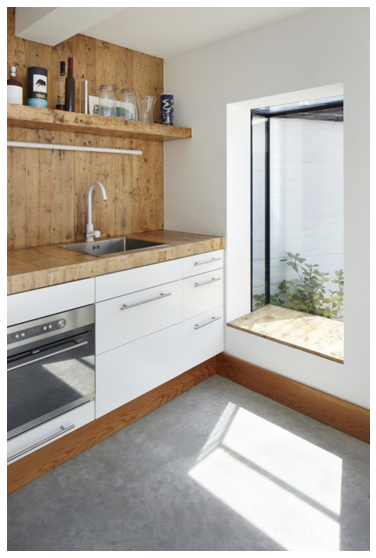

In [ ]:
df_test = df.loc[df['oven'] == True].reset_index()

random_filepath = df_test['filepath'][np.random.randint(0, len(df_test))]

showIMG(random_filepath)

https://github.com/CarterWoolsey/woodentify
https://github.com/amankharwal/Website-data/blob/master/colors.csv

# Color wheel

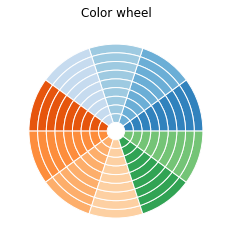

In [ ]:
fig, ax = plt.subplots()

size = 0.1
vals = np.array([[1,1] for a in range(0,10)])

color_list = [
              [[0,0,0],[70,70,70],[125,125,125]],
              [[65,36,20],[116,77,36],[166,124,82]],
              [[110,182,80],[192,212,65],[249,237,37]],
              [[0,104,55],[0,166,82],[35,181,116]],
              [[41,170,227],[86,185,224],[3,169,157]],
              [[147,43,142],[38,33,97],[16,114,187]],
              [[157,31,95],[237,37,123],[240,120,147]],
              [[194,39,45],[240,93,39],[251,176,59]],
              [[170,39,45],[231,111,51],[255,255,255]],

             ]

# cmap = plt.get_cmap("tab20c")
# outer_colors = cmap(np.arange(10))
# inner_colors = cmap(np.arange(10))



for n in range(0,9):
  ax.pie(
      vals.sum(axis=1),
      radius=1-n*size,
      colors=outer_colors,
      wedgeprops=dict(width=size, edgecolor='w')
      )

# ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
#        wedgeprops=dict(width=size, edgecolor='w'))

# ax.pie(vals.sum(axis=1), radius=1-size, colors=inner_colors,
#        wedgeprops=dict(width=size, edgecolor='w'))

# ax.pie(vals.sum(axis=1), radius=1-2*size, colors=inner_colors,
#        wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect='equal', title='Color wheel')
plt.show()

In [ ]:
inner_colors

array([[0.19215686, 0.50980392, 0.74117647, 1.        ],
       [0.41960784, 0.68235294, 0.83921569, 1.        ],
       [0.61960784, 0.79215686, 0.88235294, 1.        ],
       [0.77647059, 0.85882353, 0.9372549 , 1.        ],
       [0.90196078, 0.33333333, 0.05098039, 1.        ],
       [0.99215686, 0.55294118, 0.23529412, 1.        ],
       [0.99215686, 0.68235294, 0.41960784, 1.        ],
       [0.99215686, 0.81568627, 0.63529412, 1.        ],
       [0.19215686, 0.63921569, 0.32941176, 1.        ],
       [0.45490196, 0.76862745, 0.4627451 , 1.        ]])

# Dropout


In [ ]:
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt
# %matplotlib inline
# import argparse
# import cv2
# import numpy as np

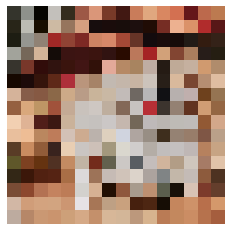

In [ ]:
# # # construct the argument parser and parse the arguments when executing in cmdline
# # ap = argparse.ArgumentParser()
# # ap.add_argument("-i", "--image", required=True, help="Path to image")
# # ap.add_argument("-c", "--clusters", required=True, type = int,
#                #help="number of clusters")
# #args = vars(ap.parse_args())

# # number of clusters
# clusters = 10

# # load the image and do conversions
# image = cv2.imread('/mydrive/data/dezeen/1594490/pantechnicon-london-store-interiors-japanese-nordic-farrells_dezeen_2364_col_29-852x568.jpg')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# # show image
# plt.figure()
# plt.axis("off")
# plt.imshow(image)

# # scale down the image
# image = cv2.resize(image, dsize=(16, 16), interpolation=cv2.INTER_CUBIC)

# # reshape the image to a list of pixels
# image = image.reshape((image.shape[0] * image.shape[1],3))


In [ ]:
# # cluster the color in the image
# clt = KMeans(n_clusters=clusters)
# clt.fit(image)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
# colours = clt.cluster_centers_
# colours

array([[ 19.13265306,  21.84693878,  40.01020408],
       [100.        , 111.86956522, 110.56521739],
       [149.48387097, 173.70967742, 172.70967742],
       [  6.78947368,  17.        , 249.        ],
       [ 54.97222222,  63.47222222,  70.11111111],
       [209.66666667, 234.83333333, 188.16666667],
       [113.29411765,  30.47058824,  42.82352941],
       [216.5       , 106.5       , 232.        ],
       [ 10.35714286,  20.        , 147.85714286],
       [101.375     , 213.25      ,  90.        ]])

In [ ]:
# def rgb_to_hsv(colour):
#     r, g, b = colour[0]/255.0, colour[1]/255.0, colour[2]/255.0
#     mx = max(r, g, b)
#     mn = min(r, g, b)
#     df = mx-mn
#     if mx == mn:
#         h = 0
#     elif mx == r:
#         h = (60 * ((g-b)/df) + 360) % 360
#     elif mx == g:
#         h = (60 * ((b-r)/df) + 120) % 360
#     elif mx == b:
#         h = (60 * ((r-g)/df) + 240) % 360
#     if mx == 0:
#         s = 0
#     else:
#         s = (df/mx)*100
#     v = mx*100
#     colours = [h, s, v]
#     return colours

In [ ]:
# colours_hsv = [rgb_to_hsv(color) for color in clt.cluster_centers_]

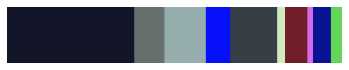

In [ ]:
# hist = centroid_histrogram(clt)
# bar = plot_color(hist, clt.cluster_centers_)

# # display
# plt.figure()
# plt.axis("off")
# valid_imshow_data(bar)
# plt.imshow(bar)
# plt.show()

In [ ]:
# hist = centroid_histrogram(clt)
# bar = plot_color(hist, colours_hsv)

# # display
# plt.figure()
# plt.axis("off")
# valid_imshow_data(bar)
# plt.imshow(bar)
# plt.show()

AttributeError: ignored

In [ ]:
# def clusterColors(filepath, clusters=10, res=(32,32)):
#   # load the image and do conversions
#   image = cv2.imread(filepath)
#   image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  
#   # reshape the image to a list of pixels
#   # image = image.reshape((image.shape[0]*image.shape[1], 3))

#   # scale down the image
#   image = cv2.resize(image, dsize=res, interpolation=cv2.INTER_CUBIC)

#   # reshape the image to a list of pixels
#   image = image.reshape((image.shape[0]*image.shape[1], 3))

#   # cluster the color in the image
#   clt = KMeans(n_clusters=clusters)
#   clt.fit(image)

#   return clt

In [ ]:
# def centroid_histrogram(clt):
#     # number of clusters
#     numLabels = np.arange(0, len(np.unique(clt.labels_))+1)
#     # histrogram of the number of pixels
#     (hist,_) = np.histogram(clt.labels_, bins = numLabels)
    
#     # normalize the histrogram, such that it sums to one'
#     hist = hist.astype("float")
#     hist /= hist.sum()
    
#     return hist

In [ ]:
# def plot_color(hist, centroids):
#     # init the rectable size
#     bar = np.zeros((50,300,3), dtype="uint8")
#     startX = 0
    
#     # loop over the percentage of each color cluster and the color of eahc cluster
#     for (percent, color) in zip(hist, centroids):
#         endX = startX + (percent*300)
#         cv2.rectangle(bar,(int(startX),0),(int(endX),50),
#                           color.astype("uint8").tolist(),-1)
#         startX = endX
    
#     return bar

In [ ]:
# def valid_imshow_data(data):
#     data = np.asarray(data)
#     if data.ndim == 2:
#         return True
#     elif data.ndim == 3:
#         if 3 <= data.shape[2] <= 4:
#             return True
#         else:
#             print('The "data" has 3 dimensions but the last dimension '
#                   'must have a length of 3 (RGB) or 4 (RGBA), not "{}".'
#                   ''.format(data.shape[2]))
#             return False
#     else:
#         print('To visualize an image the data must be 2 dimensional or '
#               '3 dimensional, not "{}".'
#               ''.format(data.ndim))
#         return False

In [ ]:
# clt.cluster_centers_

array([[131.43478261, 151.56521739, 149.2173913 ],
       [ 18.20430108,  20.83870968,  39.48387097],
       [ 80.76923077,  98.26923077,  90.26923077],
       [  6.78947368,  17.        , 249.        ],
       [176.77272727, 202.86363636, 182.18181818],
       [116.52941176,  26.47058824,  50.47058824],
       [ 47.19354839,  53.06451613,  64.16129032],
       [ 90.57142857, 211.42857143,  87.57142857],
       [ 10.35714286,  20.        , 147.85714286],
       [216.5       , 106.5       , 232.        ]])

# Test loop

In [ ]:
# start = timeit.default_timer() # start the times

# with open('/mydrive/files/tmp/dezeen-images-0.txt') as fp:
#   data = fp.read() 

# linklist = data.split('\n')
# cltlist = []
# histlist = []

# for link in tqdm(linklist):
#   try:
#     clt = clusterColors(link, 10)
#     cltlist.append(clt)
#     histlist.append(centroid_histrogram(clt))
#   except:
#     cltlist.append(np.nan)
#     histlist.append(np.nan)



# stop = timeit.default_timer() # stop the timer
# print('Runtime: {} seconds.'.format(stop-start))

Streaming output truncated to the last 5000 lines.




 50%|█████     | 1000/1999 [07:40<10:17,  1.62it/s]




 50%|█████     | 1001/1999 [07:40<09:35,  1.74it/s]




 50%|█████     | 1002/1999 [07:41<09:05,  1.83it/s]




 50%|█████     | 1003/1999 [07:41<08:44,  1.90it/s]




 50%|█████     | 1004/1999 [07:42<09:26,  1.75it/s]




 50%|█████     | 1005/1999 [07:43<10:28,  1.58it/s]




 50%|█████     | 1006/1999 [07:43<10:26,  1.59it/s]




 50%|█████     | 1007/1999 [07:44<09:41,  1.70it/s]




 50%|█████     | 1008/1999 [07:45<11:47,  1.40it/s]




 50%|█████     | 1009/1999 [07:45<10:26,  1.58it/s]




 51%|█████     | 1010/1999 [07:46<09:27,  1.74it/s]




 51%|█████     | 1011/1999 [07:46<08:32,  1.93it/s]




 51%|█████     | 1012/1999 [07:47<08:50,  1.86it/s]




 51%|█████     | 1013/1999 [07:47<08:45,  1.88it/s]




 51%|█████     | 1014/1999 [07:48<09:41,  1.69it/s]




 51%|█████     | 1015/1999 [07:49<09:41,  1.69it/s]




 51%|█████     | 1016/1999 [07:50<11:56,  1.37it/

Runtime: 1083.755972303 seconds.


In [ ]:
import sys

all_colours_in_hsv = [colour1, colour2, colour3, colour4, colour5]

def closest_colour(selected_colour):
    # set the distance to be a reallly big number
    # initialise closest_colour to empty
    shortest_distance, closest_colour = sys.max(), None

    # iterate through all the colours
    # for each colour in the list, find the Euclidean distance to the one selected by the user
    for colour in all_colours_in_hsv:
        # since your colours are in 3D space, perform the calculation in each respective space
        current_distance = sqrt(pow(colour.H - selected_colour.H, 2) + pow(colour.S - selected_colour.S, 2) + pow(colour.V - selected_colour.V, 2))

        # unless you truly care about the exact length, then you don't need to perform the sqrt() operation.
        # it is a rather expensive one so you can just do this instead
        # current_distance = pow(colour.H - selected_colour.H, 2) + pow(colour.S - selected_colour.S, 2) + pow(colour.V - selected_colour.V, 2)

        # update the distance along with the corresponding colour
        if current_distance < shortest_distance:
            shortest_distance = current_distance
            closest_colour = colour

    return shortest_distance, closest_colour

https://buzzrobot.com/dominant-colors-in-an-image-using-k-means-clustering-3c7af4622036
https://www.pyimagesearch.com/2014/05/26/opencv-python-k-means-color-clustering/
https://i.pinimg.com/236x/31/07/e7/3107e7aded0502e633a6f9b5cda52991--colour-palettes-colour-schemes.jpg
https://github.com/rodartha/ColorPalette/
https://github.com/shourya1997/K-Means-Color-Clustering/blob/master/color_kmeans.ipynb
https://medium.com/swlh/getting-dominant-colour-of-an-image-using-k-means-f7fdca880063
https://github.com/pfnet-research/FSCS
https://answers.opencv.org/question/186712/find-an-image-by-nearest-color/
https://colab.research.google.com/notebooks/bigquery.ipynb#scrollTo=XrFmZBr9KtAN
https://ailephant.com/dominant-colors-in-image-with-k-means/


# Custom model
Let's now build a custom object detection model based on the downloaded Open Images Dataset using YOLOv4.

https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects

## Classes

In [ ]:
classes = [
           'Sink',
           'Stairs',
           'Chair',
           'Cabinetry',
           'Desk',
           'Studio couch',
           'Couch',
           'Door',
           'Shower',
           'Wardrobe',
           'Nightstand',
           'Bathtub',
           'Houseplant',
           'Sofa bed',
           'Curtain',
           'Bed',
           'Fireplace',
           'Bookcase',
           'Table',
           'Mirror',
           'Chest of drawers',
           'Cupboard',
           'Coffee table',
           'Toilet',
           'Bench',
           'Window',
           'Closet',
           'Lamp',
           'Drawer',
           'Stool'
           ]

## Architecture configuration

Copy the original configuration file and perform a find-and-replace on it based on our new dataset.

- `WIDTH` & `HEIGHT` - network size as a value multiple of 32 (typically 416)
- `NUMBER_OF_CLASSES` - number of classes to train
- `MAX_BATCHES` - maximum number of samples to be propagated through the network equal `NUMBER_OF_CLASSES * 2000`
- `STEPS` - 80% & 90% of `MAX_BATCHES` in each of the `[yolo]` layers
- `FILTERS` - `3*(NUMBER_OF_CLASSES + 5)` in each of the `[convolutional]` layer before `[yolo]` layers




In [ ]:
%cd /mydrive/files/

!cp /mydrive/darknet/cfg/yolov4-custom.cfg /mydrive/files/yolov4-test.cfg

WIDTH = 416
WIDTH_ARG = 's/width=608/width={}/'.format(WIDTH)
HEIGHT = 416
HEIGHT_ARG = 's/height=608/height={}/'.format(HEIGHT)
NUMBER_OF_CLASSES = len(classes)
NUMBER_OF_CLASSES_ARG = 's/classes=80/classes={}/'.format(NUMBER_OF_CLASSES)
MAX_BATCHES = int(NUMBER_OF_CLASSES * 2000)
MAX_BATCHES_ARG = 's/max_batches\ =\ 500500/max_batches={}/'.format(MAX_BATCHES) # not less than 6000
STEPS = int(0.8*MAX_BATCHES), int(0.9*MAX_BATCHES)
STEPS_ARG = 's/steps=400000,450000/steps={},{}/'.format(STEPS[0],STEPS[1])
FILTERS = int(3*(NUMBER_OF_CLASSES + 5))
FILTERS_ARG = 's/filters=255/filters={}/'.format(FILTERS)

!sed -i {WIDTH_ARG} yolov4-test.cfg
!sed -i {HEIGHT_ARG} yolov4-test.cfg
!sed -i {NUMBER_OF_CLASSES_ARG} yolov4-test.cfg
!sed -i {MAX_BATCHES_ARG} yolov4-test.cfg
!sed -i {STEPS_ARG} yolov4-test.cfg
!sed -i {FILTERS_ARG} yolov4-test.cfg

/content/gdrive/My Drive/Colab Notebooks/dezeenAI/files


## Object names
Create a new file `obj.names` with names of the classes (one per line).

***Note:*** *If a class name has more than one word you need to replace spaces with underscore*


In [ ]:
with open('/mydrive/files/obj.names', 'w') as output:
    output.write('\n'.join([cls.replace(' ', '_') for cls in classes]))

## Datasets file lists
Create a list of files for both train and validation sets.

### Train

In [ ]:
image_files = []
DIR = '/mydrive/data/oid/train/{}/'.format('_'.join(classes))
os.chdir(DIR)

for filename in os.listdir(os.getcwd()):
  if filename.endswith('.jpg'):
    image_files.append(DIR + filename)

with open('/mydrive/files/train.txt', 'w') as outfile:
    for image in image_files:
        outfile.write(image)
        outfile.write('\n')
    outfile.close()

### Validation

In [ ]:
image_files = []
DIR = '/mydrive/data/oid/validation/{}/'.format('_'.join(classes))
os.chdir(DIR)

for filename in os.listdir(os.getcwd()):
  if filename.endswith('.jpg'):
    image_files.append(DIR + filename)

with open('/mydrive/files/valid.txt', 'w') as outfile:
    for image in image_files:
        outfile.write(image)
        outfile.write('\n')
    outfile.close()

##  Data configuration
Create a new file `obj.data` to put together data info.
- `classes` - number of classes to train
- `train` - list of files in the train dataset
- `valid` - list of files in the validation dataset
- `names` - list of classes' names
- `backup` - a directory to store partial and final weights

In [ ]:
with open('/mydrive/files/obj.data', 'w') as output:
    output.write(
        '''classes = {}
        train = /mydrive/files/train.txt
        valid = /mydrive/files/valid.txt
        names = /mydrive/files/obj.names
        backup = /mydrive/data/'''.format(len(classes))
    )

# Custom detector

## Download pre-trained weights

In [ ]:
!wget -nc https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

/content/gdrive/My Drive/Colab Notebooks/dezeenAI/files


## Train the model

- `detector`:
- `train`:
- `obj.data`: number and names of classes, list of train/val images, backup directory
- `yolov4-obj.cfg`: neural network architecture configuration
- `yolov4-obj_last.weights`: weights file
- `-dont_show`: suppress the display of an image
- `-map`:


In [ ]:
%cd /mydrive/files/
!chmod +x /mydrive/darknet/darknet
# !/mydrive/darknet/darknet detector train /mydrive/files/obj.data /mydrive/files/yolov4-obj.cfg /mydrive/data/yolov4.conv.137 -dont_show -map
!/mydrive/darknet/darknet detector train obj.data yolov4-obj.cfg yolov4-obj_last.weights -dont_show -map

Streaming output truncated to the last 5000 lines.
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 150 Avg (IOU: 0.672726, GIOU: 0.637503), Class: 0.991313, Obj: 0.153902, No Obj: 0.000270, .5R: 1.000000, .75R: 0.000000, count: 3, class_loss = 0.704299, iou_loss = 0.442179, total_loss = 1.146478 
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 161 Avg (IOU: 0.756328, GIOU: 0.739269), Class: 0.898477, Obj: 0.443157, No Obj: 0.002621, .5R: 1.000000, .75R: 0.500000, count: 8, class_loss = 1.152707, iou_loss = 0.383281, total_loss = 1.535988 
 total_bbox = 152236, rewritten_bbox = 0.777083 % 
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 139 Avg (IOU: 0.807068, GIOU: 0.804794), Class: 0.967637, Obj: 0.002077, No Obj: 0.000014, .5R: 1.000000, .75R: 1.000000, count: 1, class_loss = 0.250287, iou_loss = 6.770397, total_loss = 7.020685 
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 150 Avg (IOU: 0.698891, GIOU: 0.676555), Class: 0.986740, Obj: 0.172384, No O

In [ ]:
showIMG('chart.png')

NameError: ignored